# How to use a logistic classification regression model to predict Income bucket on census data using  BigQueryML

###### Copyright
**GUI Author:** [ Google Cloud](https://cloud.google.com/bigquery-ml/docs/logistic-regression-prediction)<br>
**Notebook Adoption Author:** [Paul Kamau](https://paulkamau.com)<br>
**Project Type:** BQML Logistic Reg<br>
**Date created:** 2022/12/10<br>
**Training Dataset** This project uses the public dataset[`census_adult_income`](https://cloud.google.com/bigquery?p=bigquery-public-data&d=census_bureau_usa&page=dataset) has about 32,561 rows of data.

## Summary
The pupose of this project is to use a binary logistic regression model in BigQuery ML to predict the income range of respondents in the US Census Dataset. The model will predict whether a US Census respondent's income falls into one of two ranges **(> 50K or < 50K a year)** based on the respondent's demographic attributes.

### Dataset
The public dataset [`census_adult_income`](https://cloud.google.com/bigquery?p=bigquery-public-data&d=census_bureau_usa&page=dataset) has about 32,561 rows of data.

This tutorial uses the following Google Cloud data analytics and ML services:

### Key Concepts
- BigQuery
- BigQuery ML
- Dimensionality Reduction
- Vertex AI Model Registry
- Vertex endpoints
- Logistic regression
- Explainable AI
- ML.EVALUATE
- ML PREDICT

### Steps
1. Create the dataset
1. Use the SELECT statement to examine the data
1. Use the CREATE VIEW statement to compile your training data
1. Use the CREATE MODEL statement to create your logistic regression model.
1. Use the ML.EVALUATE function to evaluate the model data
1. Use the ML.PREDICT function to predict the income bracket for a given set of census participants.
1. Use the ML.EXPLAIN_PREDICT function to explain prediction results with explainable AI Methods.
1. Use the ML.GLOBAL_EXPLAIN function to know which features are the most important to determine the income bracket.


### What is Logisitc Regression?

Logistic regression is a **supervised** **classification algorithm** used to assign observations to a discrete set of classes.

For example, a retailer may want to predict whether a given customer will purchase a new product, based on other information about that customer. In that case, the two labels might be **"will buy"** and **"won't buy."**

You can construct your dataset such that one column represents the **label**. The data you can use to train such a binary logistic regression model include the customer's location, their previous purchases, the customer's reported preferences, and so on.

**Types of logistic regression**
- Binary (Pass/Fail) *This tutorial as an example of one.*
- Multi (Cats, Dogs, Sheep)
- Ordinal (Low, Medium, High)

In Distiction:

**Linear Regression** is a supervised machine learning algorithm where the predicted output is **continuous** and has a constant slope. It’s used to predict values within a continuous range, **(e.g. sales, price)** rather than trying to classify them into categories (e.g. cat, dog).

## Prepare the Envrionment with Package Installs
1. Install the following packages required to execute this notebook.
1. install the workbench notebook product dependencies
1. Automatically restart kernel after installs

### Import AI Platform and ML libraries

In [1]:
import os
import sys
# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q google-cloud-bigquery db-dtypes

     |████████████████████████████████| 2.3 MB 5.1 MB/s 
     |████████████████████████████████| 215 kB 72.0 MB/s 
     |████████████████████████████████| 206 kB 58.4 MB/s 
     |████████████████████████████████| 233 kB 38.4 MB/s 


#### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [2]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython
    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

### Prepare the notebook to run in colab.

In [1]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.
import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

#### Import the Google Cloud SDK packages

In [2]:
import google.cloud.aiplatform as vertex_ai
import pandas as pd
import matplotlib.pyplot as plt
import json

from typing import Union  # This module provides runtime support for type hints
from google.cloud import bigquery
from sklearn import metrics
from google.api import httpbody_pb2

print("All imports complete")

All imports complete


#### GCP & BQML Variables

In [30]:
# Project variables
#
# These are the project variable used in this ML Model:
#

PROJECT_ID = "paulkamau" # @param {type:"string"}
BQML_MODEL_TYPE = "LOGISTIC_REG" #@param ["LINEAR_REG", "LOGISTIC_REG","KMEANS","PCA","MATRIX_FACTORIZATION","AUTOENCODER","AUTOML_REGRESSOR", "AUTOML_CLASSIFIER","BOOSTED_TREE_CLASSIFIER","BOOSTED_TREE_REGRESSOR","RANDOM_FOREST_CLASSIFIER","RANDOM_FOREST_REGRESSOR", "DNN_CLASSIFIER","DNN_REGRESSOR","DNN_LINEAR_COMBINED_CLASSIFIER", "DNN_LINEAR_COMBINED_REGRESSOR","ARIMA_PLUS","TENSORFLOW"]

BQML_MODEL_NAME = "bqml_log_reg_census_income_predict_model"
BQML_JOB_DISPLAY_NAME = BQML_MODEL_NAME + "_job"
BQML_ENDPOINT_NAME = BQML_MODEL_NAME + "_endpoint"

# datasets
BQ_DATASET_NAME = BQML_MODEL_NAME + "_dataset"
BQ_PUBLIC_DATASET = "bigquery-public-data.ml_datasets.census_adult_income"
BQ_DATASET_VIEW_TABLE= f"{BQ_DATASET_NAME}.input_view"

# bucket details
BUCKET_NAME = "bqml_tutorials"
BUCKET_URI = f"gs://{BUCKET_NAME}/{BQML_MODEL_TYPE}/"
OUTPUTBUCKET = f"gs://bqml_datasets_predictions/{BQML_MODEL_TYPE}/"

# Region
REGION = "us-central1" #@param ["us-central1", "europe-west4", "asia-east1"]

print("All variables set")

All variables set


#### Set the Service account automatically from gcloud

In [4]:
# Get your service account from gcloud
if not IS_COLAB:
    shell_output = !gcloud auth list 2>/dev/null
    SERVICE_ACCOUNT = shell_output[2].replace("*", "").strip()

else:  # IS_COLAB:
    shell_output = ! gcloud projects describe  $PROJECT_ID
    project_number = shell_output[-1].split(":")[1].strip().replace("'", "")
    SERVICE_ACCOUNT = f"{project_number}-compute@developer.gserviceaccount.com"

print("Service Account:", SERVICE_ACCOUNT)

Service Account: 993987777814-compute@developer.gserviceaccount.com


#### Initialize Vertex AI and BigQuery SDKs for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [5]:
vertex_ai.init(project=PROJECT_ID, location=REGION)

Create the BigQuery client.

In [6]:
bq_client = bigquery.Client(project=PROJECT_ID)

Use a helper function for sending queries to BigQuery.

In [7]:
# Wrapper to use BigQuery client to run query/job, return job ID or result as DF
def run_bq_query(sql: str) -> Union[str, pd.DataFrame]:
    """
    Input: SQL query, as a string, to execute in BigQuery
    Returns the query results as a pandas DataFrame, or error, if any
    """

    # Try dry run before executing query to catch any errors
    job_config = bigquery.QueryJobConfig(dry_run=True, use_query_cache=False)
    bq_client.query(sql, job_config=job_config)

    # If dry run succeeds without errors, proceed to run query
    job_config = bigquery.QueryJobConfig()
    client_result = bq_client.query(sql, job_config=job_config)

    job_id = client_result.job_id

    # Wait for query/job to finish running. then get & return data frame
    df = client_result.result().to_arrow().to_pandas()
    print(f"Finished job_id: {job_id}")
    return df

# Using BigQuery ML logistic regression model for income bucket classification on census data

BigQuery ML (BQML) provides the capability to train ML tabular models, such as classification, regression, forecasting, and matrix factorization, in BigQuery using SQL syntax directly. BigQuery ML uses the scalable infrastructure of BigQuery ML so you don't need to set up additional infrastructure for training or batch serving.

This entire demo takes less than 5 minutes to execute from start to finish. The goal however isn't to just run sql queries but to hone into the reason behind the results and how to optimize for the best outcome. Its about the patterns of thinking to apply when running through this. This is where the value really exists.

#### **Commentary**:
The public dataset we're using for this demo is the [`census_adult_income`](https://console.cloud.google.com/marketplace/product/united-states-census-bureau/us-geographic-boundaries?project=paulkamau) has about 32,561 rows of data. We will import that data and work with it inside our own datasets.

Additionally, you can find datasets in these locations depending on your use case:

1. [TensorFlow Datasets](https://www.tensorflow.org/datasets)
1. [Google Dataset Search](https://datasetsearch.research.google.com/)
1. [Google Cloud Marketplace Datasets](https://console.cloud.google.com/marketplace/browse?project=paulkamau)
1. [UCI](https://archive.ics.uci.edu/ml/datasets.php)
1. [Kaggle](https://www.kaggle.com/datasets?search=transaction)
1. [OpenML](https://www.openml.org/search?type=data&status=active&sort=runs)



### Step 1: Create Your Dataset
BigQuery organizes data tables into units called datasets. These datasets are scoped to your GCP project. Datasets are:

- Collections of “related” tables/views together with labels and description
- Allow storage access control at Dataset level
- Define location of data i.e. multi-regional (US, EU) or regional (asia-northeast1)

[Dataset SDK Reference](https://cloud.google.com/bigquery/docs/datasets-intro)

In [10]:
# check if Dataset exists.
sql_list_dataset_exists = f"""SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = '{BQ_DATASET_NAME}'"""

# Display the sql statement
print(sql_list_dataset_exists)

# execute the sql statement
run_bq_query(sql_list_dataset_exists)

print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')

SELECT count (*) FROM INFORMATION_SCHEMA.SCHEMATA WHERE schema_name = 'bqml_log_reg_census_income_predict_model_dataset'
Finished job_id: 4ff243ac-a1d1-4c0e-8429-b26583be2346
Review the Dataset in the Console:
https://console.cloud.google.com/bigquery?page=dataset&p=paulkamau&d=bqml_log_reg_census_income_predict_model_dataset&project=paulkamau


In [ ]:
sql_create_dataset = f"""CREATE SCHEMA IF NOT EXISTS {BQ_DATASET_NAME}"""

print(sql_create_dataset)

run_bq_query(sql_create_dataset)

print(f'Review the Dataset in the Console:\nhttps://console.cloud.google.com/bigquery?page=dataset&p={PROJECT_ID}&d={BQ_DATASET_NAME}&project={PROJECT_ID}')

Inspect data that has been pre-processed from  [`census_adult_income`](https://cloud.google.com/bigquery?p=bigquery-public-data&d=census_bureau_usa&page=dataset) so that it can be used for classification. (32,561 rows)

The data view results show that the **``income_bracket``** column in the census_adult_income table has only one of two values: <=50K or >50K.



In [12]:
sql_inspect_full_feature_dataset = f"""
SELECT *
FROM
 `{BQ_PUBLIC_DATASET}`
LIMIT
 10;
"""

sql_inspect_record_count_dataset = f"""
SELECT count(*)
FROM
 `{BQ_PUBLIC_DATASET}`;
"""

# Display the sql statement
print(sql_inspect_full_feature_dataset)

run_bq_query(sql_inspect_full_feature_dataset)



SELECT *
FROM
 bigquery-public-data.ml_datasets.census_adult_income
LIMIT
 10;

Finished job_id: 06bef9bf-180b-4c58-a890-11ddb2748007


,age,workclass,functional_weight,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income_bracket
0,27,Private,29261,HS-grad,9,Married-AF-spouse,Craft-repair,Husband,White,Male,0,0,40,United-States,>50K
1,47,Self-emp-not-inc,117865,HS-grad,9,Married-AF-spouse,Craft-repair,Husband,White,Male,0,0,90,United-States,<=50K
2,29,Private,95423,HS-grad,9,Married-AF-spouse,Transport-moving,Husband,White,Male,0,0,80,United-States,<=50K
3,26,Private,98155,HS-grad,9,Married-AF-spouse,Sales,Husband,White,Male,0,0,55,United-States,<=50K
4,30,Private,398827,HS-grad,9,Married-AF-spouse,Adm-clerical,Husband,White,Male,0,0,60,United-States,<=50K
5,35,Private,30565,HS-grad,9,Married-AF-spouse,Other-service,Wife,White,Female,0,0,40,United-States,>50K
6,43,Private,213844,HS-grad,9,Married-AF-spouse,Craft-repair,Wife,Black,Female,0,0,42,United-States,>50K
7,75,?,248833,HS-grad,9,Married-AF-spouse,?,Wife,White,Female,2653,0,14,United-States,<=50K
8,32,Private,281384,HS-grad,9,Married-AF-spouse,Other-service,Other-relative,White,Female,0,0,10,United-States,<=50K
9,19,Private,544091,HS-grad,9,Married-AF-spouse,Adm-clerical,Wife,White,Female,0,0,25,United-States,<=50K


#### **Commentary**:
The SQL above brings back all the features (columns) in the dataset. Not every column is going to be useful for our modeling.

**Data preparation **is required to remove duplicates, unecessary data or noise from the dataset.

The final columns (features) used for prediction are called **inputs**.

The prediction column, in this case, `income bracket`, is called **Label**. This is the purpose of this logistic classifiaction model.

#### **Questions**:
- How do you know that it was the right call to drop these columns?
- What are some training considerations to make?

In [15]:
sql_inspect_dataset = f"""
SELECT
 age,
 workclass,
 marital_status,
 education_num,
 occupation,
 hours_per_week,
 income_bracket
FROM
 `{BQ_PUBLIC_DATASET}`
LIMIT
 10;
"""
run_bq_query(sql_inspect_dataset)



Finished job_id: 90541f17-cb4d-4203-a58d-13d8fbea1395


,age,workclass,marital_status,education_num,occupation,hours_per_week,income_bracket
0,27,Private,Married-AF-spouse,9,Craft-repair,40,>50K
1,47,Self-emp-not-inc,Married-AF-spouse,9,Craft-repair,90,<=50K
2,29,Private,Married-AF-spouse,9,Transport-moving,80,<=50K
3,26,Private,Married-AF-spouse,9,Sales,55,<=50K
4,30,Private,Married-AF-spouse,9,Adm-clerical,60,<=50K
5,35,Private,Married-AF-spouse,9,Other-service,40,>50K
6,43,Private,Married-AF-spouse,9,Craft-repair,42,>50K
7,75,?,Married-AF-spouse,9,?,14,<=50K
8,32,Private,Married-AF-spouse,9,Other-service,10,<=50K
9,19,Private,Married-AF-spouse,9,Adm-clerical,25,<=50K



#### **Commentary**:

The number of **input variables** or **features** for a dataset is referred to as its dimensionality. *(See all the columns from the sql above)*

**Dimensionality reduction** refers to techniques that reduce the number of input variables in a dataset (See all the columns from the sql below)

- age,
- workclass,
- marital_status,
- education_num,
- occupation,
- hours_per_week,
- income_bracket

So what we're saying is the columns we've either dropped or consolidated have no value to our model prediction. These are the columns we've dropped;

- Dropped columns are:
- Functional weight,
- relationship,
- Education
- race,
- sex,
- capital_gain,
- capital_loss,
- native_country,

You can experiment with different numbers of columns to determine if your subsequent models are more precise, run faster, etc. Starting with a small feature set is a good way to go about it

#### **Questions**:
- How do you know that it was the right call to drop these columns?
- What are some training considerations to make?



### Step 2: Use the CREATE VIEW statement to compile the training data

The next step was to create a view that compiles the training data. This was done by selecting the data used to train your logistic regression model.

A **view** is a virtual table defined by a SQL query. When you create a view, you query it in the same way you query a table. When a user queries the view, the query results contain data only from the tables and fields specified in the query that defines the view.

The census respondent income prediction is done based on the following attributes:

In [16]:
# Create the dataset view if it doesn't exist
sql_create_dataset_view_bqml = f"""
CREATE VIEW IF NOT EXISTS {BQ_DATASET_NAME}.input_view AS
SELECT
 age,
 workclass,
 marital_status,
 education_num,
 occupation,
 hours_per_week,
 income_bracket,
 CASE
   WHEN MOD(functional_weight, 10) < 8 THEN 'training'
   WHEN MOD(functional_weight, 10) = 8 THEN 'evaluation'
   WHEN MOD(functional_weight, 10) = 9 THEN 'prediction'
 END AS dataframe
FROM
`{BQ_PUBLIC_DATASET}`
"""

run_bq_query(sql_create_dataset_view_bqml)

Finished job_id: 4f008f4d-3c72-45d0-8e0b-81b5c4d638de


""


In [17]:
# We can examine the view data using the sql below
sql_examine_view_data = f"""
SELECT *
FROM {BQ_DATASET_NAME}.input_view;
"""

run_bq_query(sql_examine_view_data)

Finished job_id: d68b4cef-d815-4cac-9723-9d18c963e914


,age,workclass,marital_status,education_num,occupation,hours_per_week,income_bracket,dataframe
0,27,Private,Married-AF-spouse,9,Craft-repair,40,>50K,training
1,47,Self-emp-not-inc,Married-AF-spouse,9,Craft-repair,90,<=50K,training
2,29,Private,Married-AF-spouse,9,Transport-moving,80,<=50K,training
3,26,Private,Married-AF-spouse,9,Sales,55,<=50K,training
4,30,Private,Married-AF-spouse,9,Adm-clerical,60,<=50K,training
...,...,...,...,...,...,...,...,...
32556,64,Private,Married-spouse-absent,10,Exec-managerial,40,<=50K,training
32557,24,Private,Married-spouse-absent,10,Adm-clerical,45,<=50K,training
32558,44,Private,Married-spouse-absent,10,Craft-repair,45,<=50K,training
32559,30,Private,Married-spouse-absent,10,Exec-managerial,45,<=50K,training


### Step 3: Use the CREATE MODEL statement to create your logistic regression model.

The query below trains a logistic regression model using BigQuery ML. BigQuery resources are used to train the model.

View the **BQML model** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create) reference

In [18]:
#
# Let's check if the model already exists.
# Note: We're tapping into the python notebook's integration with vertex without invoking sql in any way.
#
model = vertex_ai.Model(model_name=BQML_MODEL_NAME)

print(model.gca_resource)

print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')



name: "projects/993987777814/locations/us-central1/models/bqml_log_reg_census_income_predict_model"
display_name: "bqml_log_reg_census_income_predict_model"
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "bigquery"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
supported_output_storage_formats: "bigquery"
create_time {
  seconds: 1667581691
  nanos: 345408000
}
update_time {
  seconds: 1667581732
  nanos: 587274000
}
deployed_models {
  endpoint: "projects/993987777814/locations/us-central1/endpoints/1139626210003779584"
  deployed_model_id: "1547676965304008704"
}
deployed_models {
  endpoint: "projects/993987777814/locations/us-central1/endpoints/1139626210003779584"
  deployed_model_id: "5009493723403255808"
}
etag: "AMEw9yMrN-U

In [28]:
#
# Create the training job. this cell may take ~1 min to run
#

sql_train_bqml_model_job = f"""
CREATE MODEL IF NOT EXISTS {BQ_DATASET_NAME}.{BQML_MODEL_NAME} OPTIONS (
  model_type = "{BQML_MODEL_TYPE}",
  auto_class_weights = TRUE,
  input_label_cols = ['income_bracket'],
  model_registry = "vertex_ai",
  early_stop = TRUE,
  vertex_ai_model_version_aliases = ['logistic_reg', 'experimental']
) AS
SELECT
  *
EXCEPT
(dataframe)
FROM
  {BQ_DATASET_VIEW_TABLE} --The SELECT statement queries the view from Step 3.
WHERE
  dataframe = 'training' --since we're using 80% of our data for training
"""

print(sql_train_bqml_model_job)

run_bq_query(sql_train_bqml_model_job)

print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/bigquery?referrer=search&project={PROJECT_ID}&ws=!1m5!1m4!5m3!1s{PROJECT_ID}!2s{BQ_DATASET_NAME}!3s{BQML_MODEL_NAME}')


CREATE MODEL IF NOT EXISTS bqml_log_reg_census_income_predict_model_dataset.bqml_log_reg_census_income_predict_model OPTIONS (
  model_type = "LOGISTIC_REG",
  auto_class_weights = TRUE,
  input_label_cols = ['income_bracket'],
  model_registry = "vertex_ai",
  early_stop = TRUE,
  vertex_ai_model_version_aliases = ['logistic_reg', 'experimental']
) AS
SELECT 
  *
EXCEPT
(dataframe)
FROM
  bqml_log_reg_census_income_predict_model_dataset.input_view --The SELECT statement queries the view from Step 3.
WHERE
  dataframe = 'training' --since we're using 80% of our data for training

Finished job_id: b8abe22d-5290-4a6a-8a10-0babe94ded2b
Review the Model in the Console:
https://console.cloud.google.com/bigquery?referrer=search&project=paulkamau&ws=!1m5!1m4!5m3!1spaulkamau!2sbqml_log_reg_census_income_predict_model_dataset!3sbqml_log_reg_census_income_predict_model


In the `OPTIONS` parameter:
* with `model_registry="vertex_ai"`, the BigQuery ML model will automatically be <a href="https://cloud.google.com/vertex-ai/docs/model-registry/model-registry-bqml" target="_blank">registered to Vertex AI Model Registry</a>, which enables you to view all of your registered models and its versions on Google Cloud in one place.
- `auto_class_weights` = TRUE, this Balances the class labels in the training data

- input_label_cols = ['income_bracket'], This is the prediction column our model should figure out. A binary option of >50 or < 50

* `vertex_ai_model_version_aliases allows you to set aliases to help you keep track of your model version [Doc](https://cloud.google.com/vertex-ai/docs/model-registry/model-alias)


### Step3b. Use the ML.TRAINING_INFO to see the training iterations and details of the model

The ML.TRAINING_INFO [function](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-train) allows you to see information about the training iterations of a model. ML.TRAINING_INFO can be run while the CREATE MODEL query is running, or after it is run. If you run a query that contains ML.TRAINING_INFO before the first training iteration is complete, the query returns a Not found error.

In [23]:
# Here's where we're using the bq client because of the additional features to tap into matplotlib.

sql_training_info_model = bq_client.query(
    query = f"""
        SELECT *
        FROM ML.TRAINING_INFO(MODEL `{PROJECT_ID}.{BQ_DATASET_NAME}.{BQML_MODEL_NAME}`)
        ORDER BY iteration
        """
).to_dataframe()

sql_training_info_model

,training_run,iteration,loss,eval_loss,learning_rate,duration_ms
0,0,0,0.665961,0.666653,0.2,2944
1,0,1,0.622384,0.624493,0.4,3456
2,0,2,0.562807,0.567438,0.8,3365
3,0,3,0.497042,0.504751,1.6,3224
4,0,4,0.453079,0.462806,3.2,3330
5,0,5,0.445936,0.456382,6.4,2903
6,0,6,0.392152,0.402187,12.8,3574



#### **Commentary**:
We can observe that the model training had 7 Iterations (starting at 0)

**Training run**

The value in this column is zero for a newly created model. If you retrain the model using warm_start (new training data), this value is incremented.

**iteration**

The iteration number of the training run. its how many times the model algorithm has attempted to optimize the loss. The value for the first iteration is zero. This value is incremented for each additional training run.

Note: Iterations and epochs are not the same.  *Iterations* is the number of batches (size of data passed) needed to complete one epoch. One Epoch is when an **ENTIRE** dataset is passed forward and backward through the neural network only ONCE.

**loss**

A *loss function* is a function that compares the target and predicted output values; measures how well the neural network models the training data. When training, we aim to minimize this loss between the predicted and target outputs.

**eval_loss**

The loss metric calculated on the holdout data.

**Learning_rate**

a tuning parameter in an optimization algorithm that determines the step size at each iteration while moving toward a minimum of a loss function.

**duration_ms** How long the iteration took, in milliseconds.


### Step3c. Let's take a look at the Loss History

Y axis = loss (high at the beginning. goal is to bring it low)

X axis = eval_loss ()


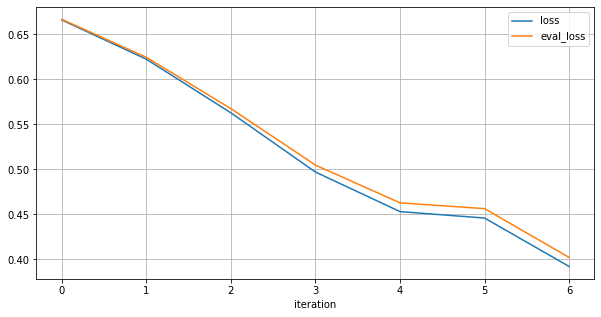

In [24]:
sql_training_info_model.plot(x = 'iteration', y = ['loss','eval_loss'], figsize = (10, 5), grid = True)

### Step 4: Use the ML.EVALUATE function to evaluate the model data
The ML.EVALUATE function is used to evaluate model metrics. It reports the precision, recall, accuracy, f1_score, log_loss * roc_auc

Machine learning model evaluation metrics are used to

1. assess quality of fit between the model and the data,
2. compare different models, and
3. in the context of model selection, and to predict how accurate each model can be expected to perform on a specific data set.

Read the **BQML ML EVALUATE function** [doc](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate) reference

With the model created, you can now evaluate the logistic regression model. Behind the scenes, BigQuery ML automatically <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create#data_split_method" target="_blank">split the data</a>, which makes it easier to quickly train and evaluate models.


In [19]:
sql_evaluate_model = f"""
SELECT
  *
FROM
  ML.EVALUATE(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME})
"""

print(sql_evaluate_model)

run_bq_query(sql_evaluate_model)


SELECT
  *
FROM
  ML.EVALUATE(MODEL bqml_log_reg_census_income_predict_model_dataset.bqml_log_reg_census_income_predict_model)

Finished job_id: 9022c701-e47d-4b77-acff-6dff548ff75a


,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,0.581818,0.750586,0.808175,0.655514,0.402187,0.881006


Another Query for getting evaluation metrics broken out by test, validate and training sets.

In [37]:
sql_evaluate_model_all_splits = f"""
SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
    (SELECT * FROM {BQ_DATASET_VIEW_TABLE} WHERE dataframe = 'evaluation'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
    (SELECT * FROM {BQ_DATASET_VIEW_TABLE} WHERE dataframe = 'prediction'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
    (SELECT * FROM {BQ_DATASET_VIEW_TABLE} WHERE dataframe = 'training'))
"""

print(sql_evaluate_model_all_splits)

run_bq_query(sql_evaluate_model_all_splits)


SELECT 'TEST' as SPLIT, * FROM ML.EVALUATE(MODEL bqml_log_reg_census_income_predict_model_dataset.bqml_log_reg_census_income_predict_model,
    (SELECT * FROM bqml_log_reg_census_income_predict_model_dataset.input_view WHERE dataframe = 'evaluation'))
UNION ALL
SELECT 'VALIDATE' as SPLIT, * FROM ML.EVALUATE(MODEL bqml_log_reg_census_income_predict_model_dataset.bqml_log_reg_census_income_predict_model,
    (SELECT * FROM bqml_log_reg_census_income_predict_model_dataset.input_view WHERE dataframe = 'prediction'))
UNION ALL
SELECT 'TRAIN' as SPLIT, * FROM ML.EVALUATE(MODEL bqml_log_reg_census_income_predict_model_dataset.bqml_log_reg_census_income_predict_model,
    (SELECT * FROM bqml_log_reg_census_income_predict_model_dataset.input_view WHERE dataframe = 'training'))

Finished job_id: 4ee08eb8-f588-417d-b137-ce4d7f92dfa9


,SPLIT,precision,recall,accuracy,f1_score,log_loss,roc_auc
0,TEST,0.571574,0.764946,0.815561,0.654271,0.395796,0.882432
1,VALIDATE,0.595573,0.758974,0.812222,0.667418,0.398843,0.881753
2,TRAIN,0.589010,0.749091,0.813194,0.659475,0.394167,0.883797



#### **Commentary**:
When evaluating model metrics, a rule of thumb is, what does 0 mean, what does 1 mean? The way I go about it is literally to start at Google when I'm unsure. Something like:

**F1_Score**: This is the most [important](https://wiki.pathmind.com/accuracy-precision-recall-f1) metric IMO.

F1 is an overall measure of a model’s accuracy that combines *precision* and *recall*.

An F1 score is considered perfect when it’s 1, while the model is a total failure when it’s 0. In our model results, we have an F1 score of **.65 ** or **65%** which is not a total failure or a total success.

**Precision**:
The percentage of predictions that were **correct (positive)**. The higher the precision, the fewer false positives predicted.

Here the model identified the `income_bracket` with a precision score of **0.58**, which meant that this model was correct *58%* of the time.

**Recall**:

The percentage of all ground truth items that were successfully predicted by the model.

The higher the recall, the fewer false negatives, or the fewer predictions missed.

Here the model identified the `income_bracket` recall score of **0.75** which means the model correctly classified 75% of all the census respondent buckets in the test data

**Accuracy**: *How often is our model correct?*
- [What does a good accuracy score look like?](https://www.google.com/search?q=What+is+a+good+AUC+ROC+score%3F&ei=-f-UY-T3HYuNggff94GwCg&ved=0ahUKEwik2PL2hPD7AhWLhuAKHd97AKYQ4dUDCBA&uact=5&oq=What+is+a+good+AUC+ROC+score%3F&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIECAAQHjIFCAAQhgMyBQgAEIYDMgUIABCGAzIFCAAQhgMyBQgAEIYDOgcIABAeELADOggIABCGAxCwAzoGCAAQFhAeSgQIQRgBSgQIRhgAUFpY5wlggQxoAXAAeACAAWGIAeMBkgEBM5gBAKABAcgBBsABAQ&sclient=gws-wiz-serp) subjective but anything greater than 70% is a great model performance.

Accuracy is the fraction of predictions our model got right. This is the # of correct predictions (income_bracket correctly classified) over the Total # of predictions.

Here the model identified the `income_bracket` accuracy score of **0.80** which means the model correctly classified 80% of all the census respondent buckets in the test data

**Log_loss**:
[Log-loss](https://towardsdatascience.com/intuition-behind-log-loss-score-4e0c9979680a#:~:text=Log%2Dloss%20is%20indicative%20of,is%20the%20log%2Dloss%20value) is indicative of how close the prediction probability is to the corresponding actual/true value (<=50K or >=50k for income_bracket). The more the predicted probability diverges from the actual value, the higher is the log-loss value.

Here the model has a log loss of **0.40** which means the prediction probability is close to the actual label when compared to the training data. The lower the log loss, the better the model.

**ROC_AUC**:
- [What does a good AUC ROC score look like?](https://www.google.com/search?q=What+is+a+good+AUC+ROC+score%3F&ei=-f-UY-T3HYuNggff94GwCg&ved=0ahUKEwik2PL2hPD7AhWLhuAKHd97AKYQ4dUDCBA&uact=5&oq=What+is+a+good+AUC+ROC+score%3F&gs_lcp=Cgxnd3Mtd2l6LXNlcnAQAzIECAAQHjIFCAAQhgMyBQgAEIYDMgUIABCGAzIFCAAQhgMyBQgAEIYDOgcIABAeELADOggIABCGAxCwAzoGCAAQFhAeSgQIQRgBSgQIRhgAUFpY5wlggQxoAXAAeACAAWGIAeMBkgEBM5gBAKABAcgBBsABAQ&sclient=gws-wiz-serp) Answer is between 0.8-0.9.

AUC - ROC curve is a performance measurement for the classification problems at various threshold settings.

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes.

![AUC ROC](https://stephenallwright.com/content/images/2022/08/roc-auc-curve-diagram.png?ezimgfmt=rs:466x466/rscb1/ng:webp/ngcb1)

#### **Questions**:
- Did our selection of the features we used for training affect these model evaluations?


There are various metrics for logistic regression and other model types (full list of metrics can be found in the <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-evaluate#mlevaluate_output" target="_blank">documentation</a>).

### Step 5: Use the ML.PREDICT function to predict the income bracket for a given set of census participants.

Finally, you use the [ML.PREDICT](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict) function to predict the income bracket for a given set of census participants.

In [ ]:
# Recap of what's in our view data.

# We can examine the view data using the sql below.
sql_examine_view_data = f"""
SELECT * FROM {BQ_DATASET_NAME}.input_view WHERE dataframe='prediction';
"""

run_bq_query(sql_examine_view_data)

In [40]:
# We are using the remainder of our data ot perform predictions by limiting the dataframe to "PREDICTION". About 3142 rows.

sql_ml_predict = f"""
SELECT * FROM
 ML.PREDICT (MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
   (SELECT income_bracket AS original_income_bracket,age,workclass,marital_status,education_num,occupation,hours_per_week,dataframe FROM {BQ_DATASET_NAME}.input_view
   WHERE dataframe = 'prediction')
 ) LIMIT 5
"""
print(sql_ml_predict)

run_bq_query(sql_ml_predict)


SELECT * FROM
 ML.PREDICT (MODEL bqml_log_reg_census_income_predict_model_dataset.bqml_log_reg_census_income_predict_model,
   (SELECT income_bracket AS original_income_bracket,age,workclass,marital_status,education_num,occupation,hours_per_week,dataframe FROM bqml_log_reg_census_income_predict_model_dataset.input_view
   WHERE dataframe = 'prediction')
 ) LIMIT 5

Finished job_id: f5320361-ed58-4f84-bb03-2f034793eaa5


,predicted_income_bracket,predicted_income_bracket_probs,original_income_bracket,age,workclass,marital_status,education_num,occupation,hours_per_week,dataframe
0,>50K,"[{'label': ' >50K', 'prob': 0.8012037958878487...",<=50K,19,Federal-gov,Married-AF-spouse,9,Sales,40,prediction
1,<=50K,"[{'label': ' >50K', 'prob': 0.0130342090738352...",>50K,49,Local-gov,Widowed,5,Handlers-cleaners,40,prediction
2,<=50K,"[{'label': ' >50K', 'prob': 0.0261415586919522...",<=50K,76,?,Widowed,5,?,25,prediction
3,<=50K,"[{'label': ' >50K', 'prob': 0.0116911768749607...",<=50K,73,Private,Widowed,5,Other-service,9,prediction
4,<=50K,"[{'label': ' >50K', 'prob': 0.069907715855004}...",<=50K,59,Private,Widowed,6,Machine-op-inspct,52,prediction



#### **Commentary**:
When the ML predict function runs, it generates 2 new columns. These are:
1. predicted_income_bracket
1. predicted_income_bracket_probs

The `predicted_income_bracket` has the classfication predictions of the original `income_bracket` label.

The `predicted_income_bracket_probs` contains the probability scores for each of the binary options.

Lets take a look at **row 3 **who's prediction results are as follows:
```
predicted_income_bracket = <=50K
predicted_income_bracket_probs	=
{'label': ' >50K', 'prob': 0.011691176874960766}
{'label': ' <=50K','prob': 0.9883088231250392}
income_bracket = <=50k,
```
The model's income_bracket probability was 1% for >50K, and 98% for <=50k based on the inputs provided. This matched the dataset original label.

```
age = 73,
workclass=Private,
marital_status=Widowed,
education_num=5,
occupation=Other-service
hours_per_week=0
```


### Step 6: Use the ML.EXPLAIN_PREDICT function to know which features are the most important to determine the weight

To understand why the model is generating these prediction results, you can use the ML.EXPLAIN_PREDICT function.


<a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a> has built-in <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-xai-overview" target="_blank">Explainable AI</a>. This allows you to see the top contributing features to each prediction and interpret how it was computed.

In [42]:
sql_explain_predict = f"""

SELECT * FROM
ML.EXPLAIN_PREDICT(MODEL {BQ_DATASET_NAME}.{BQML_MODEL_NAME},
 (
  SELECT income_bracket AS original_income_bracket,age,workclass,marital_status,education_num,occupation,hours_per_week,dataframe FROM {BQ_DATASET_NAME}.input_view
  WHERE dataframe = 'prediction'),
  STRUCT(3 as top_k_features)
 ) LIMIT 5
"""

run_bq_query(sql_explain_predict)

Finished job_id: 0d2e9430-15c9-4d71-97c3-7e8dfb776043


,predicted_income_bracket,probability,top_feature_attributions,baseline_prediction_value,prediction_value,approximation_error,income_bracket,age,workclass,marital_status,education_num,occupation,hours_per_week,dataframe
0,>50K,0.801204,"[{'feature': 'marital_status', 'attribution': ...",-0.298787,1.393835,0.0,<=50K,19,Federal-gov,Married-AF-spouse,9,Sales,40,prediction
1,<=50K,0.986966,"[{'feature': 'education_num', 'attribution': -...",-0.298787,-4.327058,0.0,>50K,49,Local-gov,Widowed,5,Handlers-cleaners,40,prediction
2,<=50K,0.973858,"[{'feature': 'education_num', 'attribution': -...",-0.298787,-3.617740,0.0,<=50K,76,?,Widowed,5,?,25,prediction
3,<=50K,0.988309,"[{'feature': 'education_num', 'attribution': -...",-0.298787,-4.437161,0.0,<=50K,73,Private,Widowed,5,Other-service,9,prediction
4,<=50K,0.930092,"[{'feature': 'marital_status', 'attribution': ...",-0.298787,-2.588108,0.0,<=50K,59,Private,Widowed,6,Machine-op-inspct,52,prediction



#### **Commentary**:
![AUC ROC](https://github.com/paulycloud/ml_portfolio/blob/main/02_BigQuery_ML/02_census_logistic_reg/assets/ml_explain_predict.png?raw=true)

When the ML.EXPLAIN_PREDICT function runs, it generates 6 new columns. These are:
1. predicted_income_bracket
1. probability
1. top_feature_attributions
1. baseline_prediction_value
1. prediction_value
1. approximation_error

Lets take a look at **row 3** who's prediction results are as follows:

```
predicted_income_bracket = <=50K
probability=0.9883088231250392
top_feature_attributions= ['education_num', 'marital_status','age']
baseline_prediction_value=-0.29878674958313467
prediction_value=-4.437160778853922
approximation_error=0.0

age = 73,
workclass=Private,
marital_status=Widowed,
education_num=5,
occupation=Other-service
hours_per_week=0
```

The `predicted_income_bracket` has the classfication predictions of the original `income_bracket` label. In this case, its <=50K

The `probability` contains the probability scores for each of the binary options in this case its 98%.

The `top_feature_attributions` this is an array containing the 3 top features contributng to the prediction. In this case, Education_num, marital_status and age are the top factors.

The `baseline_prediction_value` is the mean across all numerical features and NULL for other types of features.

The `prediction_value` contains the probability scores for each of the binary options.

The `approximation_error` The exact attribution methods like Tree SHAP have the property such that baseline_prediction_value + {sigma} feature_attribution


### Step 7: Inspect the model on Vertex AI Model Registry

When the model was trained in BigQuery ML, the line `model_registry="vertex_ai"` registered the model to Vertex AI Model Registry automatically upon completion.

You can view the model on the <a href="https://console.cloud.google.com/vertex-ai/models" target="_blank">Vertex AI Model Registry page</a>, or use the code below to check that it was successfully registered:

In [47]:
model = vertex_ai.Model(model_name=BQML_MODEL_NAME)
print(f'Review the Model in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/models/{BQML_MODEL_NAME}?project={PROJECT_ID}')

print(model.gca_resource)



Review the Model in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/models/bqml_log_reg_census_income_predict_model?project=paulkamau
name: "projects/993987777814/locations/us-central1/models/bqml_log_reg_census_income_predict_model"
display_name: "bqml_log_reg_census_income_predict_model"
supported_deployment_resources_types: DEDICATED_RESOURCES
supported_input_storage_formats: "jsonl"
supported_input_storage_formats: "bigquery"
supported_input_storage_formats: "csv"
supported_input_storage_formats: "tf-record"
supported_input_storage_formats: "tf-record-gzip"
supported_input_storage_formats: "file-list"
supported_output_storage_formats: "jsonl"
supported_output_storage_formats: "bigquery"
create_time {
  seconds: 1667581691
  nanos: 345408000
}
update_time {
  seconds: 1667581732
  nanos: 587274000
}
deployed_models {
  endpoint: "projects/993987777814/locations/us-central1/endpoints/1139626210003779584"
  deployed_model_id: "1547676965304008704"
}
deplo

### Step 8: Create the endpoint and Deploy the model to an endpoint
Endpoints are machine learning models made available for online prediction requests. Endpoints are useful for timely predictions from many users (for example, in response to an application request). You can also request batch predictions if you don't need immediate results.

While BigQuery ML supports batch prediction with <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-predict" target="_blank">ML.PREDICT</a> and <a href="https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-explain-predict" target="_blank">ML.EXPLAIN_PREDICT</a>, BigQuery ML is not suitable for real-time predictions where you need low latency predictions with potentially high frequency of requests.

In other words, deploying the BigQuery ML model to an endpoint enables you to do online predictions.


#### Create a Vertex AI endpoint

To deploy your model to an endpoint, you will first need to create an endpoint before you deploy the model to it.

In [49]:
# create an endpoint if it doesn't exist
endpoints = vertex_ai.Endpoint.list(filter = f"display_name={BQML_ENDPOINT_NAME}")

if endpoints:
    endpoint = endpoints[0]
    print(f"Endpoint Exists: {endpoints[0].display_name}")
else:
    endpoint = vertex_ai.Endpoint.create(
    display_name=BQML_ENDPOINT_NAME,
    location=REGION,
    project=PROJECT_ID,
    )
    print(f"Endpoint Created: {endpoint.display_name}")

print(f'Review the Endpoint in the Console:\nhttps://console.cloud.google.com/vertex-ai/locations/{REGION}/endpoints/{endpoint.name}?project={PROJECT_ID}')

print(endpoint.display_name)
print(endpoint.resource_name)

Endpoint Exists: bqml_log_reg_census_income_predict_model_endpoint
Review the Endpoint in the Console:
https://console.cloud.google.com/vertex-ai/locations/us-central1/endpoints/1139626210003779584?project=paulkamau
bqml_log_reg_census_income_predict_model_endpoint
projects/993987777814/locations/us-central1/endpoints/1139626210003779584


#### Deploy model to Vertex endpoint

With the new endpoint, you can now deploy your model.

In [ ]:
# deploying the model to the endpoint may take 10-15 minutes
# Check if Model Deployment Exists
deployments = vertex_ai.Endpoint.list(filter = f"display_name={BQML_ENDPOINT_NAME}")

if deployments:
    deployment = deployments[0]
    print(f"Deployment Exists: {deployments[0].display_name}")
else:
    model.deploy(endpoint=endpoint)
    print(f"Model deployment Created: {endpoint.display_name}")

You can also check on the status of your model by visiting the <a href="https://console.cloud.google.com/vertex-ai/endpoints" target="_blank">Vertex AI Endpoints page</a>.

### Step 9: Make online predictions to the endpoint

Using a sample of the training data, you can test the endpoint to make online predictions.

In [55]:
df_sample_requests_list = [
    {
        "age": 45,
        "workclass": "Public",
        "marital_status": "Single",
        "education_num": 6,
        "occupation": "Exec-managerial",
        "hours_per_week": 40,
    },
    {
        "age": 30,
        "workclass": "Private",
        "marital_status": "Married",
        "education_num": 2,
        "occupation": "Machine-op-inspct",
        "hours_per_week": 50,
    }
]

In [70]:
prediction = endpoint.predict(df_sample_requests_list)
print(prediction)

Prediction(predictions=[{'predicted_income_bracket': [' <=50K'], 'income_bracket_probs': [0.2098744173305852, 0.7901255826694148], 'income_bracket_values': [' >50K', ' <=50K']}, {'income_bracket_values': [' >50K', ' <=50K'], 'income_bracket_probs': [0.06176187987532602, 0.938238120124674], 'predicted_income_bracket': [' <=50K']}], deployed_model_id='1547676965304008704', model_version_id='1', model_resource_name='projects/993987777814/locations/us-central1/models/bqml_log_reg_census_income_predict_model', explanations=None)


You can then extract the predictions from the prediction response

In [69]:
# to view the prediction for the first row
prediction.predictions[1]['predicted_income_bracket']

[' <=50K']

## Cleaning up

To clean up all Google Cloud resources used in this project, you can <a href="https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects" target="_blank">delete the Google Cloud
project</a> you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [ ]:
# Undeploy model from endpoint and delete endpoint
endpoint.undeploy_all()
endpoint.delete()

# Delete BigQuery dataset, including the BigQuery ML model
! bq rm -r -f $PROJECT_ID:$BQ_DATASET_NAME